# Advanced Lane Detection

## (using Deep Learning)




### Import TensorFlow and Keras libraries

We will start by importing all the necessary libraries for Keras and TensorFlow. Apart from these libraries, we will also import some other libraries such as NumPy, Glob, cv2, csv, and MatPlotLib.


In [1]:
import os
import csv
import cv2
import numpy as np
import keras
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import math

from scipy import ndimage

from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D, Cropping2D, Dropout
from keras.preprocessing.image import ImageDataGenerator

import sklearn
from sklearn.model_selection import train_test_split

import GPUtil as GPU

Using TensorFlow backend.


## GPU information

Here, we will print some information related to GPU memory capacity. The user can accordingly make modifications to the code in case of more/less capacity.

In [2]:
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
print("Total Available GPU memory: {} MB".format(gpu.memoryTotal))
print("Used GPU memory: {} MB".format(gpu.memoryUsed))
print("Total Free GPU memory: {} MB".format(gpu.memoryFree))

Total Available GPU memory: 4096.0 MB
Used GPU memory: 764.0 MB
Total Free GPU memory: 3332.0 MB


## Check library versions

Here, we print the versions of tensorflow, keras and OpenCV versions to compare compatibility.

In [3]:
# printing installed tensorflow/keras/OpenCV versions
print("Current OpenCV version:", cv2.__version__)
print("Using TensorFlow version:", tf.__version__)
print("Using Keras version:", keras.__version__)

Current OpenCV version: 3.4.2
Using TensorFlow version: 2.1.0
Using Keras version: 2.3.1


## Data Augmentation

We use this cell to activate data augmentation. This step is highly advised to correct for any undesired bias in the model. We create a bool parameter. If set to True, we will perform data augmentation.

(Note: This step may take a significant amount of time depending on the size of the original data).

In [4]:
# setting data augmentation activation to True/False

augment_data = False

## Dataset building and Augmentation

Here, we load the data from the *driving_log.csv* file and if required, augment the data by flipping the images in the opposite direction.

In [5]:
# 1. Start of dataset building
## Read the csv file containing saved model data

lines = []
with open('./model_data.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

# empty list to store images
images = []

# lists to save polynomial measurements for left and right lanes
measurements = []

# directory for accessing binary images
directory = '../data_for_lane_detection/binary_images/'
# directory = '../data_for_lane_detection/lanelines_images/'
directory = '../data_for_lane_detection/transformed_images/'

if (augment_data):
    print("Performing data augmentation by flipping the images ...\n")

    

for line in lines:

    # reading filesnames for binary images and lanelines images
    fname_binary_img = line[0]
    # fname_transformed_img = line[1]

    # reading images using opencv
    bin_img = mpimg.imread(fname_binary_img)
    # laneline_img = mpimg.imread(fname_lanelines_img)
    # transformed_img = mpimg.imread(fname_transformed_img)
    
    # adding images to the lists
    images.append(bin_img)
    # images.append(transformed_img)
    
    # adding steering angles for center. left and right images
    measurement1 = []
    measurement1.append(float(line[1]))
    measurement1.append(float(line[2]))
    measurement1.append(float(line[3]))
    measurement1.append(float(line[4]))
    measurement1.append(float(line[5]))
    measurement1.append(float(line[6]))
    # measurement1.append(float(line[7]))
    
    measurements.append(measurement1)

    # only if data augmentation is required
    if (augment_data):

        transformed_img_flipped = np.fliplr(transformed_img)
        images.append(transformed_img_flipped)
        
        # flip the measurements
        left_measurements_a_flip = -(float(line[1]))
        left_measurements_b_flip = -(float(line[2]))
        left_measurements_c_flip = -(float(line[3]))
        right_measurements_a_flip = -(float(line[4]))
        right_measurements_b_flip = -(float(line[5]))
        right_measurements_c_flip = -(float(line[6]))
        
        # add the flipped measurements to the current measurements lists
        measurements.append(left_measurements_a_flip)
        measurements.append(left_measurements_b_flip)
        measurements.append(left_measurements_c_flip)
        measurements.append(right_measurements_a_flip)
        measurements.append(right_measurements_b_flip)
        measurements.append(right_measurements_c_flip)


# define arrays for datasets
X_train = np.array(images)
measurements = np.array(measurements)

print(X_train.shape)
print(measurements.shape)

(5796, 270, 480, 3)
(5796, 6)


## Display sample flipped images

This is the procedure I used to augment the data. The image was flipped from left to right. Here is a sample flipped image.

In [6]:
# select a random image from the dataset

if (augment_data):
    idx = random.randint(0, len(X_train))
    img = X_train[idx]
    flipped_img = np.fliplr(img)

    measure = measurements[idx]

    plt.figure(1)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 20))

    ax1.imshow(img)
    ax1.set_title('Original Image, measuremnets = ' + str(measurements[idx]) , fontsize=20)
    ax2.imshow(flipped_img)
    ax2.set_title('Flipped Image, measurements = ', fontsize=20)
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
else:
    print("Note: Data Augmentation is turned off!!!")
    print("Hence, no flipped images are displayed!")

Note: Data Augmentation is turned off!!!
Hence, no flipped images are displayed!


### Print Dataset information

We will print information regarding the dataset here. We will also print information after data augmentation. For each laneline, we have a set of three polynomial coefficients.

In [7]:
# function to print the dataset information
def print_dataset_info():

    if (augment_data):
        # print out array shapes and details
        print("Original Dataset information ---\n")
        # print("Image shape: ", X_train[0][1])
        print("Measurement Sets:", 0.5*len(measurements))
        print("Total images:", 0.5*X_train.shape[0])
        print()

        print("Augmented Dataset information ---\n")
        # print("Image shape: ", X_train[0][1])
        print("Measurement sets after augmentation:", len(measurements))
        print("Total images after augmentation:", X_train.shape[0])
        print()
    else:
        # print out array shapes and details
        print("Original Dataset information ---\n")
        # print("Image shape: ", X_train[0][1])
        print("Measurement Sets:", len(measurements))
        print("Total images:", X_train.shape[0])
        
print(X_train.shape)
print(measurements.shape)

(5796, 270, 480, 3)
(5796, 6)


In [8]:
print_dataset_info()

Original Dataset information ---

Measurement Sets: 5796
Total images: 5796


### Display a sample image

Here, we display a random sample image along with the drawn detected lanelines. We also print some characteristics of the lanelines polynomials.

Image id -  1000967
(270, 480, 3)


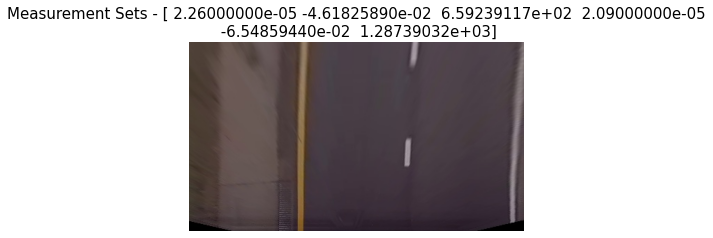

In [9]:
idx = random.randint(0, len(X_train))
sample_img = X_train[idx]
print("Image id - ", (1000001 + idx))
print(sample_img.shape)
plt.imshow(sample_img)
plt.axis('off')
plt.title("Measurement Sets - " + str(measurements[idx]), fontsize=15)
plt.show()

## Network Architecture

Now, we will define our Convolutional Neural Network here comtaining 6 convolutional layers, 4 fully connected layers and some dropout and lambda layers in between. We will use a dropout layer after the 6th convolutional layers and set the number of epochs to 10.


In [10]:
# Batch size, epochs and pool size below are all paramaters to fiddle with for optimization
batch_size = 150
epochs = 10
pool_size = (2, 2)

# 2. Start of Network Architecture
# NVIDIA network architecture
model = Sequential()

# Normalizes incoming inputs. First layer needs the input shape to work
# model.add(BatchNormalization(input_shape=(270, 480, 3)))

# image preprocessing - normalizing the pixel values and cropping the image
model.add(Lambda(lambda x:(x/127.5)-1.0, input_shape=(270,480,3)))

'''
# add a cropping layer here if necessary
# For example : cropping top 50 pixels and 20 pixels from the bottom
model.add(Cropping2D(cropping=((0,0),(100,100)), input_shape=(540,960,3)))
'''


# 1st Convolutional layer
model.add(Conv2D(64, (5, 5), activation="relu", strides = (2,2)))
# 2nd Convolutional layer
model.add(Conv2D(36, (5, 5), activation="relu", strides = (2,2)))
# 3rd Convolutional layer
model.add(Conv2D(48, (5, 5), activation="relu", strides=(2,2)))
# 4th Convolutional layer
model.add(Conv2D(64, (3, 3), activation="relu"))
# 5th Convolutional layer
model.add(Conv2D(64, (3, 3), activation="relu"))
# 6th Convolutional layer
model.add(Conv2D(64, (3, 3), activation="relu"))

model.add(Dropout(0.5))

# Pooling
model.add(MaxPooling2D(pool_size=pool_size))

# Flatten and Dropout
model.add(Flatten())

# FC Layer 1
model.add(Dense(128))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
# FC Layer 2
model.add(Dense(64))
model.add(Activation('relu'))
# FC Layer 3
model.add(Dense(32))
model.add(Activation('relu'))

# final layer to decide the 6 laneline polynomial coefficients
model.add(Dense(6))
model.add(Activation('relu'))


# Compiling and training the model
# Currently using MAE instead of MSE as MSE tends to only have 1 label for left curve, 1 for right curve, and 1 for straight (nothing in between)
model.compile(optimizer='Adam', loss='mean_absolute_error')

# fit model with a validation set of 20%
history_object = model.fit(X_train, measurements, validation_split=0.2, shuffle=True, epochs=10)

model.save('model.h5')

Train on 4636 samples, validate on 1160 samples
Epoch 1/10
4636/4636 [==============================] - 125s 27ms/step - loss: 230.9004 - val_loss: 252.0169
Epoch 2/10
4636/4636 [==============================] - 112s 24ms/step - loss: 61.3478 - val_loss: 131.1018
Epoch 3/10
4636/4636 [==============================] - 113s 24ms/step - loss: 21.6882 - val_loss: 138.2664
Epoch 4/10
4636/4636 [==============================] - 112s 24ms/step - loss: 21.1699 - val_loss: 120.7117
Epoch 5/10
4636/4636 [==============================] - 111s 24ms/step - loss: 20.7664 - val_loss: 154.8194
Epoch 6/10
4636/4636 [==============================] - 114s 25ms/step - loss: 15.1740 - val_loss: 135.5368
Epoch 7/10
4636/4636 [==============================] - 117s 25ms/step - loss: 17.3790 - val_loss: 129.8644
Epoch 8/10
4636/4636 [==============================] - 115s 25ms/step - loss: 14.5139 - val_loss: 149.4734
Epoch 9/10
4636/4636 [==============================] - 114s 25ms/step - loss: 14.0136 

## Model Summary

Print the model summary.

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 270, 480, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 133, 238, 64)      4864      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 117, 36)       57636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 57, 48)        43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 55, 64)        27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 53, 64)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 51, 64)       

## Print Loss

Print the training loss. We will also plot a graph of training loss (mean squared error loss) vs no of epochs. This is just to get an idea of how the loss goes on reducing 

dict_keys(['val_loss', 'loss'])


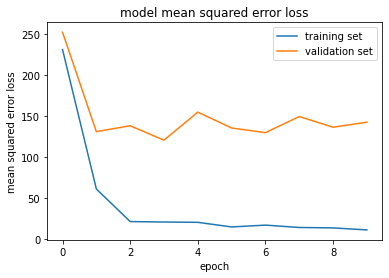

In [13]:
print(history_object.history.keys())

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')

plt.legend(['training set', 'validation set'], loc='upper right')

plt.show()
